In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import seaborn as sns

import numpy as np
import pandas as pd
import renders as rs
from IPython.display import display

## Load Data

In [3]:
filename = "./data/food.xlsx"

In [4]:
try:
    df = pd.read_excel(filename)
    #data.drop(['Region', 'Channel'], axis = 1, inplace = True)
    print "Food customers dataset has {} samples with {} features each.".format(*df.shape)
except:
    print "Dataset could not be loaded. Is the dataset missing?"

Food customers dataset has 10000 samples with 11 features each.


In [5]:
df.columns

Index([u'customer_id', u'First Time', u'Recent Time', u'# of Orders',
       u'# of Orders in last 7 days', u'# of Orders in last 4 weeks',
       u'Amount', u'Amount in last 7 days', u'Amount in last 4 weeks',
       u'Avg_DistanceFromResturant', u'Avg_DeliveryTime'],
      dtype='object')

# Run basic sanity checks

1) if any user(user id) appears more than once 

        if yes, are the rest of data fields of the 2 records same ? (if not, this relfects data inconsistency)
        

In [6]:
user_ids_set = df['customer_id'].tolist()
user_ids_set_size = len(user_ids_set)

if (user_ids_set_size < len(df)):
    print "data duplication"


In [7]:
user_ids_set_size

10000

# Data Exploration

In [8]:
# Display a description of the dataset
display(df.describe())

,customer_id,# of Orders,# of Orders in last 7 days,# of Orders in last 4 weeks,Amount,Amount in last 7 days,Amount in last 4 weeks,Avg_DistanceFromResturant,Avg_DeliveryTime
count,1.000000e+04,10000.000000,1923.000000,4341.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000
mean,6.714023e+05,7.006200,1.734789,3.197650,2253.273600,109.497500,455.491200,2.35620,36.914300
std,3.901880e+05,13.118619,1.369875,3.940818,5136.484499,397.055277,1237.872749,0.97492,13.175413
min,2.800000e+01,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,-0.80000,15.000000
25%,3.365148e+05,1.000000,1.000000,1.000000,279.000000,0.000000,0.000000,1.70000,26.000000
50%,6.683395e+05,2.000000,1.000000,2.000000,688.000000,0.000000,0.000000,2.40000,36.500000
75%,1.005002e+06,7.000000,2.000000,4.000000,2040.000000,0.000000,398.000000,3.02500,47.000000
max,1.355445e+06,212.000000,14.000000,46.000000,138808.000000,10150.000000,26853.000000,5.90000,83.000000


# Understand the spread of this data across time

In [9]:
start_time = pd.to_datetime(df['First Time'], format='%Y-%m-%d %H:%M:%S.%f')

In [10]:
end_time = pd.to_datetime(df['Recent Time'], format='%Y-%m-%d %H:%M:%S.%f')

In [11]:
min(start_time), max(start_time)

(Timestamp('2015-06-05 17:21:00'), Timestamp('2016-01-07 12:42:00'))

In [12]:
min(end_time), max(end_time)

(Timestamp('2015-06-08 22:07:00'), Timestamp('2016-01-13 05:54:00'))

In [13]:
min(start_time), max(end_time)

(Timestamp('2015-06-05 17:21:00'), Timestamp('2016-01-13 05:54:00'))

In [14]:
df['time range'] = end_time - start_time

In [15]:
df['time range'][0]

Timedelta('163 days 15:21:00')

In [16]:
min(df['time range']), max(df['time range'])

(Timedelta('0 days 00:01:00'), Timedelta('168 days 04:37:00'))

In [17]:
df['days'] = df['time range'].apply(lambda x: float(x.days))

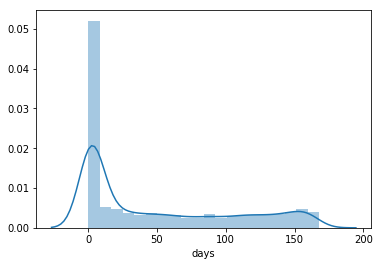

In [18]:
sns.distplot(df['days'])

# Lets identify customers who have churned

Given the simple data, we are going to use a very naive way to identify churn

Some definitions we use:

*definnately_churned_away* = no orders in 1 month.





In [19]:
df[df['Amount in last 4 weeks'] == 0].count()

customer_id                    5660
First Time                     5660
Recent Time                    5660
# of Orders                    5660
# of Orders in last 7 days        1
# of Orders in last 4 weeks       1
Amount                         5660
Amount in last 7 days          5660
Amount in last 4 weeks         5660
Avg_DistanceFromResturant      5660
Avg_DeliveryTime               5660
time range                     5660
days                           5660
dtype: int64

These 5660 customers have not made any order in last 30 days. They are candiadtes for customer retention efforts. 

# Identify customers who are likely to be unhappy

Unhappy can have many definitions based on quality of food, experience etc. 

Here we use a simple definition = average distance is low but average delivery time is high.

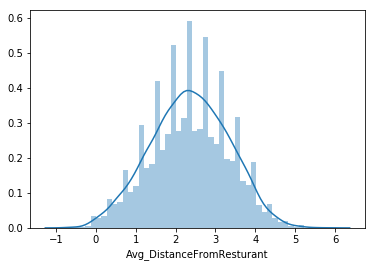

In [20]:
# plot av. distance distribution

#df['Avg_DistanceFromResturant'].plot.hist()
sns.distplot(df['Avg_DistanceFromResturant'])

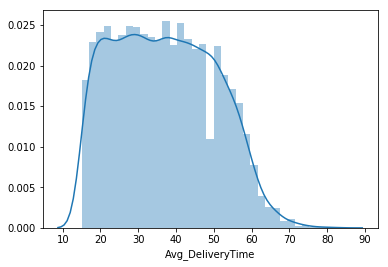

In [21]:
#df['Avg_DeliveryTime'].plot.hist(alpha=0.5)

sns.distplot(df['Avg_DeliveryTime'])

In [22]:
# 3D plot

In [23]:
df[(df['Avg_DistanceFromResturant'] < 1.5) & (df['Avg_DeliveryTime'] > 45)].count()

customer_id                    441
First Time                     441
Recent Time                    441
# of Orders                    441
# of Orders in last 7 days      70
# of Orders in last 4 weeks    141
Amount                         441
Amount in last 7 days          441
Amount in last 4 weeks         441
Avg_DistanceFromResturant      441
Avg_DeliveryTime               441
time range                     441
days                           441
dtype: int64

If the business has set some SLA based on distance and time - highly likely these 441 customers are likely to 
brech the SLA

# More Exploration - Feature Relevance

In [24]:
df2 = df.copy(deep=True) ## retain original datafram

In [25]:
df['# of Orders in last 3 weeks'] = df['# of Orders in last 4 weeks'] - df['# of Orders in last 7 days']

In [26]:
df['Amount in last 3 weeks'] = df['Amount in last 4 weeks'] - df['Amount in last 7 days']

In [27]:
# remove all NaNs - 
df = df.dropna()

In [28]:
f1 = df['# of Orders'].values
f2 = df['# of Orders in last 7 days'].values
#f3 = df['# of Orders in last 4 weeks'].values
f4 = df['# of Orders in last 3 weeks'].values

f5 = df['Amount'].values
#f6 = df['Amount in last 7 days'].values
#f7 = df['Amount in last 4 weeks'].values
f8 = df['Amount in last 3 weeks'].values

f9 = df['Avg_DistanceFromResturant'].values
f10 = df['Avg_DeliveryTime'].values
f11 = df['days'].values

In [29]:
data = np.matrix(zip(f1,f2, f4, f5, f8, f9, f10, f11))

In [30]:
data.shape

(1923, 8)

In [31]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, df['Amount in last 7 days'], test_size=0.25, random_state=0)

/Users/admin/.virtualenvs/keras_2_0/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [32]:
# Create a decision tree regressor and fit it to the training set
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor(random_state=42)
regressor.fit(X_train, y_train)

# Report the score of the prediction using the testing set
score = regressor.score(X_test, y_test)
print score

0.00159882717404


These featres are not very helpful in predicting "Amount in last 7 days"

# Visualize Feature Distributions

In [33]:
df = df.drop(['customer_id', '# of Orders in last 4 weeks', 'Amount in last 4 weeks', 
               'First Time', 'Recent Time', 'time range'], axis = 1)

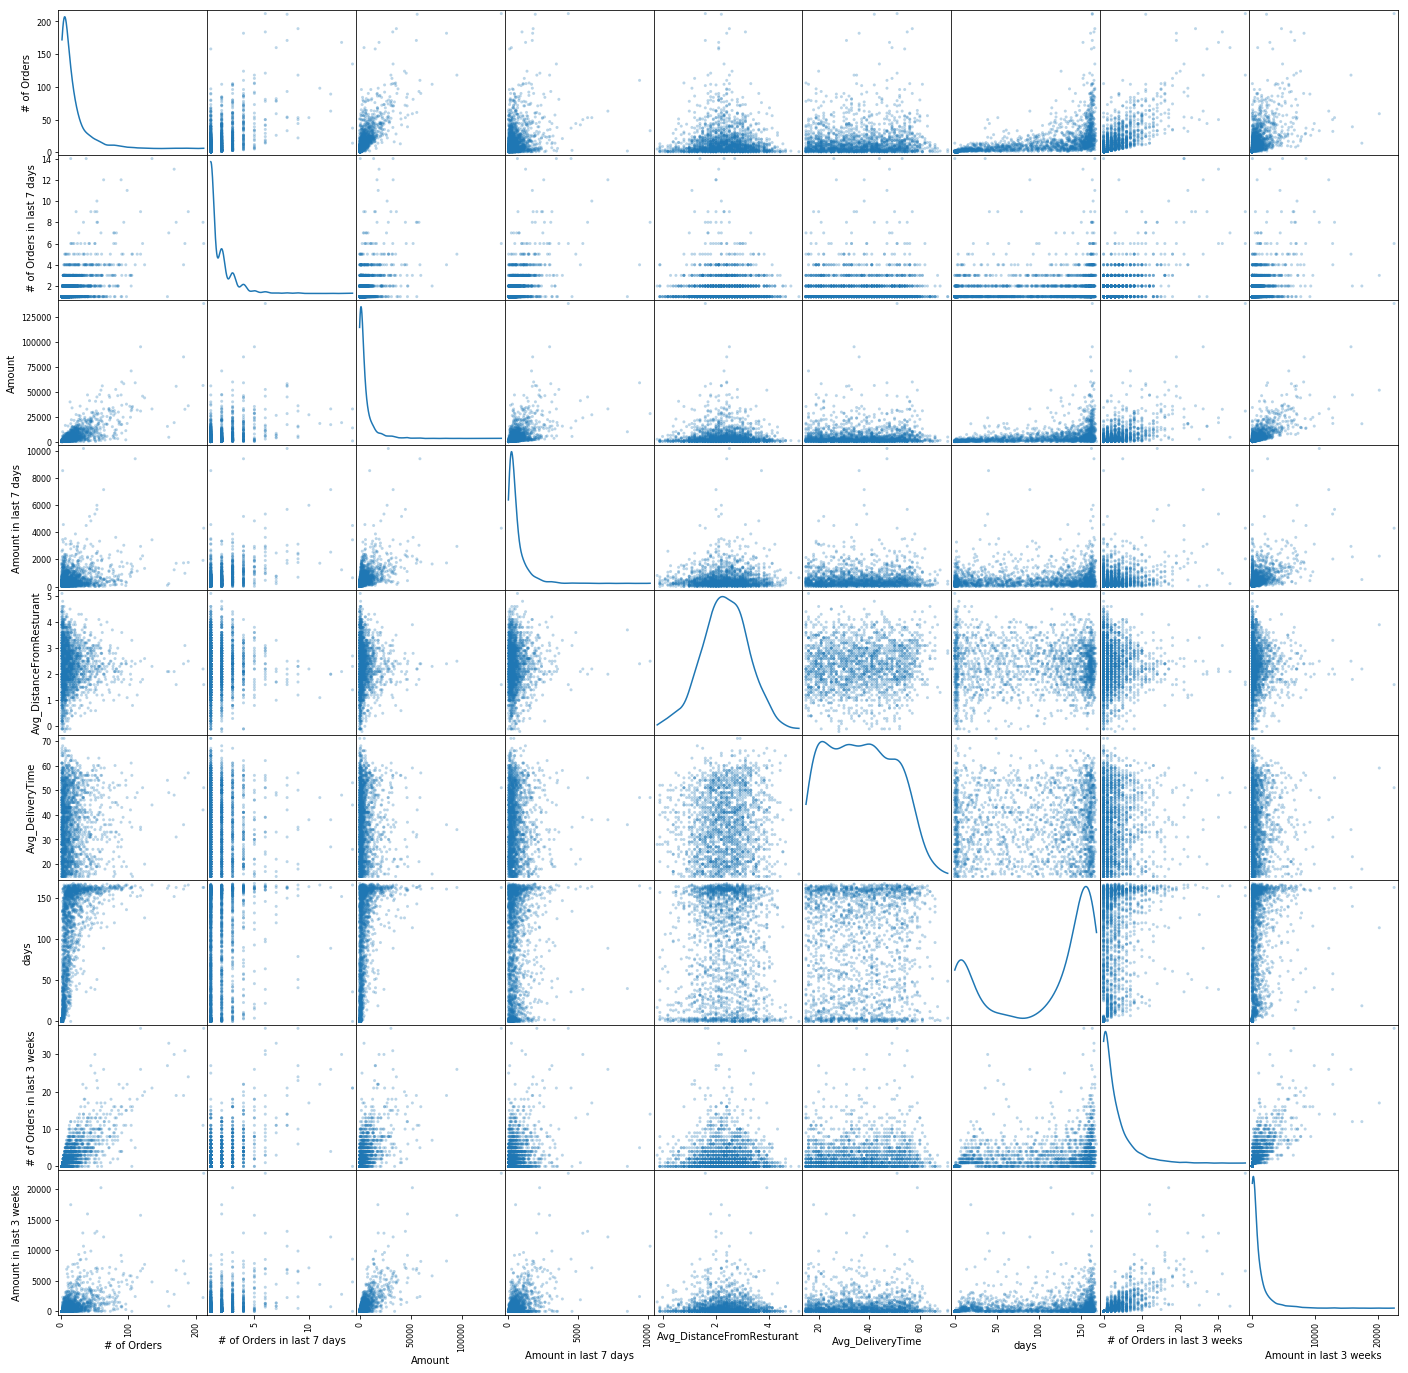

In [34]:
# Produce a scatter matrix for each pair of features in the data
pd.plotting.scatter_matrix(df, alpha = 0.3, figsize = (24,24), diagonal = 'kde');

# Visualize log of Feature Distribution

Tried with normal values didnt get good results. This is primarily because different attributes have values at different scale. Tired various normalizations - log did best.

In [35]:
# applying a natural logarithm scaling to the data, the distribution of each feature should appear much more normal.
log_data = np.log(df)


/Users/admin/.virtualenvs/keras_2_0/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/Users/admin/.virtualenvs/keras_2_0/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


In [36]:
log_data = log_data.replace([np.inf, -np.inf], np.nan)

In [37]:
log_data = log_data.dropna()

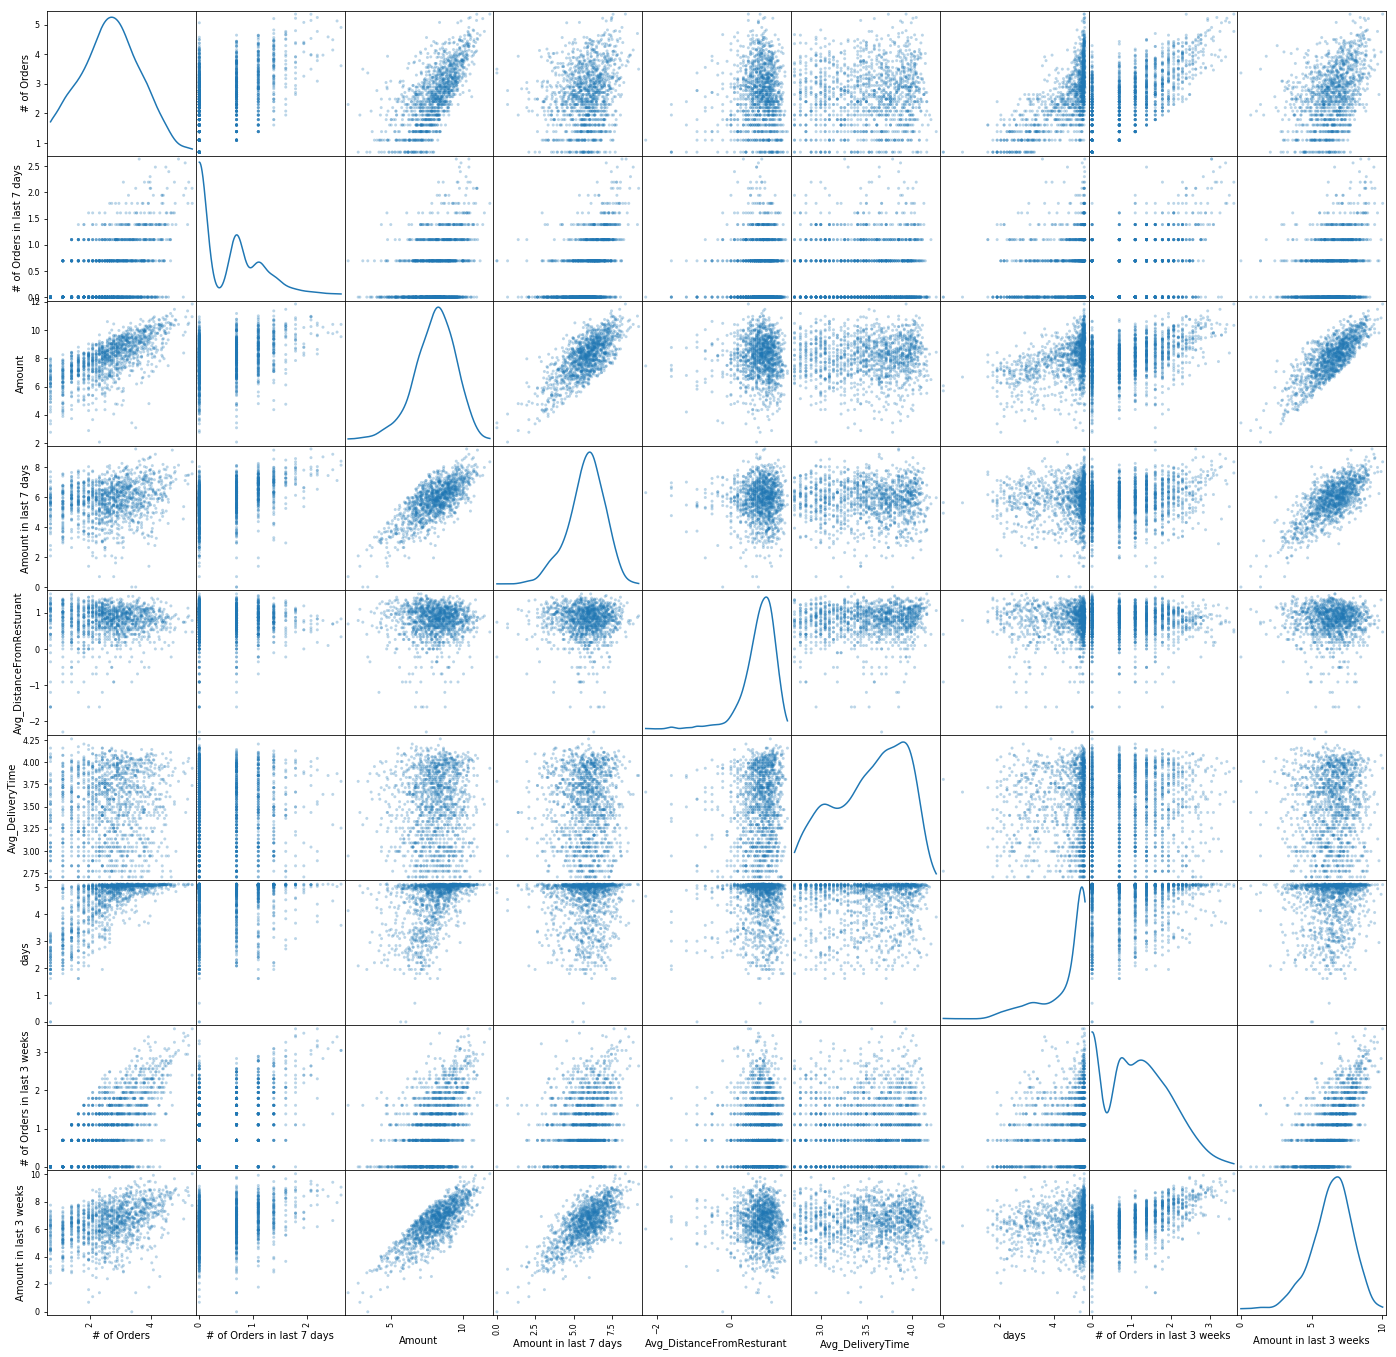

In [38]:
# Produce a scatter matrix for each pair of newly-transformed features
pd.plotting.scatter_matrix(log_data, alpha = 0.3, figsize = (24,24), diagonal = 'kde');

In [39]:
data = df.dropna()

In [40]:
data

,# of Orders,# of Orders in last 7 days,Amount,Amount in last 7 days,Avg_DistanceFromResturant,Avg_DeliveryTime,days,# of Orders in last 3 weeks,Amount in last 3 weeks
0,212,6.0,138808,4291,1.6,51,163.0,37.0,22562
1,211,8.0,56404,1925,2.2,42,163.0,11.0,2252
2,189,9.0,36020,1772,2.5,57,166.0,24.0,4632
3,184,6.0,32489,975,3.1,55,165.0,31.0,6135
4,182,4.0,85150,1738,2.4,36,161.0,19.0,8220
5,171,8.0,55597,1710,1.6,31,163.0,19.0,6726
6,168,13.0,19055,1231,2.1,48,152.0,30.0,2783
8,160,7.0,4343,215,2.1,49,165.0,33.0,845
9,158,1.0,15279,94,2.1,54,162.0,27.0,3242
11,135,14.0,32799,3436,2.3,44,166.0,21.0,4803


In [41]:
# For each feature find the data points with extreme high or low values
for feature in log_data.keys():
    
    #  Calculate Q1 (25th percentile of the data) for the given feature
    Q1 = np.percentile(log_data[feature], 25)
    
    #  Calculate Q3 (75th percentile of the data) for the given feature
    Q3 = np.percentile(log_data[feature], 75)
    
    # Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
    step = 1.5 * (Q3 - Q1)
    
    # Display the outliers
    print "Data points considered outliers for the feature '{}':".format(feature)
    display(log_data[~((log_data[feature] >= Q1 - step) & (log_data[feature] <= Q3 + step))])

Data points considered outliers for the feature '# of Orders':


,# of Orders,# of Orders in last 7 days,Amount,Amount in last 7 days,Avg_DistanceFromResturant,Avg_DeliveryTime,days,# of Orders in last 3 weeks,Amount in last 3 weeks
0,5.356586,1.791759,11.840847,8.364275,0.470004,3.931826,5.09375,3.610918,10.024022
1,5.351858,2.079442,10.940295,7.562681,0.788457,3.737670,5.09375,2.397895,7.719574


Data points considered outliers for the feature '# of Orders in last 7 days':


,# of Orders,# of Orders in last 7 days,Amount,Amount in last 7 days,Avg_DistanceFromResturant,Avg_DeliveryTime,days,# of Orders in last 3 weeks,Amount in last 3 weeks
0,5.356586,1.791759,11.840847,8.364275,0.470004,3.931826,5.093750,3.610918,10.024022
1,5.351858,2.079442,10.940295,7.562681,0.788457,3.737670,5.093750,2.397895,7.719574
2,5.241747,2.197225,10.491830,7.479864,0.916291,4.043051,5.111988,3.178054,8.440744
3,5.214936,1.791759,10.388657,6.882437,1.131402,4.007333,5.105945,3.433987,8.721765
5,5.141664,2.079442,10.925885,7.444249,0.470004,3.433987,5.093750,2.944439,8.813736
6,5.123964,2.564949,9.855085,7.115582,0.741937,3.871201,5.023881,3.401197,7.931285
8,5.075174,1.945910,8.376321,5.370638,0.741937,3.891820,5.105945,3.496508,6.739337
11,4.905275,2.639057,10.398153,8.142063,0.832909,3.784190,5.111988,3.044522,8.476996
14,4.795791,1.791759,10.729241,7.721349,0.587787,3.931826,5.075174,2.944439,8.853951
16,4.770685,2.197225,10.331529,7.619724,0.530628,3.555348,5.030438,3.610918,8.795431


Data points considered outliers for the feature 'Amount':


,# of Orders,# of Orders in last 7 days,Amount,Amount in last 7 days,Avg_DistanceFromResturant,Avg_DeliveryTime,days,# of Orders in last 3 weeks,Amount in last 3 weeks
0,5.356586,1.791759,11.840847,8.364275,0.470004,3.931826,5.093750,3.610918,10.024022
390,3.496508,0.693147,3.091042,0.000000,0.741937,3.295837,4.795791,1.609438,1.386294
469,3.367296,0.693147,3.433987,0.000000,-0.223144,3.784190,4.948760,0.000000,0.000000
1135,2.772589,0.000000,4.060443,0.693147,0.587787,3.218876,4.543295,1.791759,3.091042
1470,2.484907,1.386294,4.369448,3.135494,0.993252,2.995732,4.043051,1.945910,3.951244
1781,2.302585,0.693147,2.079442,0.693147,0.693147,2.944439,4.127134,1.609438,1.386294
1971,2.197225,0.693147,4.356709,2.944439,0.587787,3.713572,4.174387,0.693147,3.135494
2135,2.079442,0.000000,3.663562,2.079442,1.029619,3.663562,4.736198,0.000000,1.098612
2394,1.945910,0.000000,2.890372,1.386294,1.098612,3.433987,5.049856,0.000000,0.693147
2581,1.945910,0.000000,4.304065,3.091042,0.741937,4.007333,5.099866,0.000000,1.609438


Data points considered outliers for the feature 'Amount in last 7 days':


,# of Orders,# of Orders in last 7 days,Amount,Amount in last 7 days,Avg_DistanceFromResturant,Avg_DeliveryTime,days,# of Orders in last 3 weeks,Amount in last 3 weeks
19,4.700480,1.386294,10.987172,9.147933,0.875469,3.850148,5.105945,1.609438,7.791936
99,4.143135,2.484907,10.399829,8.871505,0.693147,3.637586,4.488636,3.258097,9.405660
104,4.127134,0.000000,8.082402,2.772589,0.875469,3.931826,5.111988,1.098612,4.770685
172,3.931826,1.098612,4.795791,1.386294,0.405465,3.433987,5.081404,1.386294,1.791759
390,3.496508,0.693147,3.091042,0.000000,0.741937,3.295837,4.795791,1.609438,1.386294
391,3.496508,2.079442,10.244805,9.225229,0.916291,3.850148,5.087596,2.639057,9.273315
469,3.367296,0.693147,3.433987,0.000000,-0.223144,3.784190,4.948760,0.000000,0.000000
746,3.091042,0.000000,5.872118,2.639057,0.875469,2.944439,5.081404,0.693147,3.367296
783,3.044522,0.693147,4.691348,1.945910,0.916291,4.007333,5.099866,1.609438,3.258097
993,2.833213,0.000000,6.269096,1.945910,0.262364,3.135494,5.010635,0.693147,3.258097


Data points considered outliers for the feature 'Avg_DistanceFromResturant':


,# of Orders,# of Orders in last 7 days,Amount,Amount in last 7 days,Avg_DistanceFromResturant,Avg_DeliveryTime,days,# of Orders in last 3 weeks,Amount in last 3 weeks
20,4.663439,1.609438,10.472176,7.303843,-0.223144,2.708050,5.056246,2.772589,8.475329
166,3.931826,0.693147,10.609625,7.257003,-0.510826,4.025352,4.836282,0.693147,7.026427
238,3.784190,0.693147,9.008224,5.736572,-0.510826,3.465736,4.955827,1.945910,7.140453
276,3.688879,0.693147,9.343734,6.244167,-0.356675,2.772589,5.043425,1.609438,7.256297
361,3.555348,0.000000,10.028577,6.278521,-0.693147,3.465736,5.030438,1.098612,7.587817
469,3.367296,0.693147,3.433987,0.000000,-0.223144,3.784190,4.948760,0.000000,0.000000
479,3.367296,0.000000,9.650465,5.407172,-0.916291,3.912023,5.056246,1.098612,7.516977
538,3.295837,1.098612,8.212297,6.084499,-0.356675,2.708050,4.969813,0.000000,4.584967
808,2.995732,0.000000,8.225503,5.446737,-0.223144,3.871201,4.919981,1.609438,6.522093
1064,2.833213,1.098612,9.037890,7.336937,-0.223144,3.931826,4.941642,0.000000,5.707110


Data points considered outliers for the feature 'Avg_DeliveryTime':


,# of Orders,# of Orders in last 7 days,Amount,Amount in last 7 days,Avg_DistanceFromResturant,Avg_DeliveryTime,days,# of Orders in last 3 weeks,Amount in last 3 weeks


Data points considered outliers for the feature 'days':


,# of Orders,# of Orders in last 7 days,Amount,Amount in last 7 days,Avg_DistanceFromResturant,Avg_DeliveryTime,days,# of Orders in last 3 weeks,Amount in last 3 weeks
1548,2.484907,1.098612,8.108623,6.505784,0.916291,3.784190,2.772589,2.197225,7.883823
1641,2.397895,1.386294,8.404472,7.121252,0.875469,4.025352,1.945910,1.945910,8.079928
1886,2.302585,1.609438,6.118097,5.252273,0.336472,3.637586,2.708050,1.609438,5.572154
2158,2.079442,0.000000,8.870242,5.459586,1.163151,3.737670,2.639057,1.945910,8.836665
2233,2.079442,1.098612,7.030857,6.084499,-0.223144,3.970292,2.564949,1.609438,6.539586
2380,1.945910,0.693147,7.617268,6.383507,0.693147,3.891820,2.079442,1.609438,7.273093
2416,1.945910,0.000000,8.163656,7.153834,0.741937,3.784190,2.772589,1.791759,7.710653
2533,1.945910,1.098612,7.753624,6.903747,1.335001,3.401197,2.772589,1.386294,7.195937
2611,1.945910,0.000000,7.562681,5.365976,0.587787,2.772589,2.484907,1.791759,7.444833
2668,1.791759,0.000000,5.820083,3.737670,-0.916291,3.178054,2.564949,1.609438,5.686975


Data points considered outliers for the feature '# of Orders in last 3 weeks':


,# of Orders,# of Orders in last 7 days,Amount,Amount in last 7 days,Avg_DistanceFromResturant,Avg_DeliveryTime,days,# of Orders in last 3 weeks,Amount in last 3 weeks


Data points considered outliers for the feature 'Amount in last 3 weeks':


,# of Orders,# of Orders in last 7 days,Amount,Amount in last 7 days,Avg_DistanceFromResturant,Avg_DeliveryTime,days,# of Orders in last 3 weeks,Amount in last 3 weeks
0,5.356586,1.791759,11.840847,8.364275,0.470004,3.931826,5.093750,3.610918,10.024022
75,4.290459,0.000000,7.815611,4.465908,1.131402,3.761200,5.105945,0.000000,2.564949
172,3.931826,1.098612,4.795791,1.386294,0.405465,3.433987,5.081404,1.386294,1.791759
390,3.496508,0.693147,3.091042,0.000000,0.741937,3.295837,4.795791,1.609438,1.386294
469,3.367296,0.693147,3.433987,0.000000,-0.223144,3.784190,4.948760,0.000000,0.000000
712,3.091042,1.386294,5.017280,3.295837,1.163151,3.912023,4.727388,1.098612,2.890372
731,3.091042,0.693147,5.686975,3.044522,1.098612,3.135494,5.003946,0.000000,2.944439
1358,2.564949,0.693147,5.929589,4.317488,0.587787,3.891820,5.081404,0.000000,2.397895
1781,2.302585,0.693147,2.079442,0.693147,0.693147,2.944439,4.127134,1.609438,1.386294
1974,2.197225,0.000000,7.058758,6.011267,1.163151,4.043051,4.997212,0.000000,2.484907


In [ ]:
# outliers have been removed. whatever remains is good data

In [42]:
good_data = log_data 

In [55]:
good_data.shape

(1306, 9)

# PCA

We want to discover which dimensions about the data best maximize the variance of features involved. In addition to finding these dimensions, PCA will also report the explained variance ratio of each dimension — how much variance within the data is explained by that dimension alone.

In [43]:
from sklearn.decomposition import PCA
import renders as rs

pca = PCA(n_components=8)
pca = pca.fit(good_data)

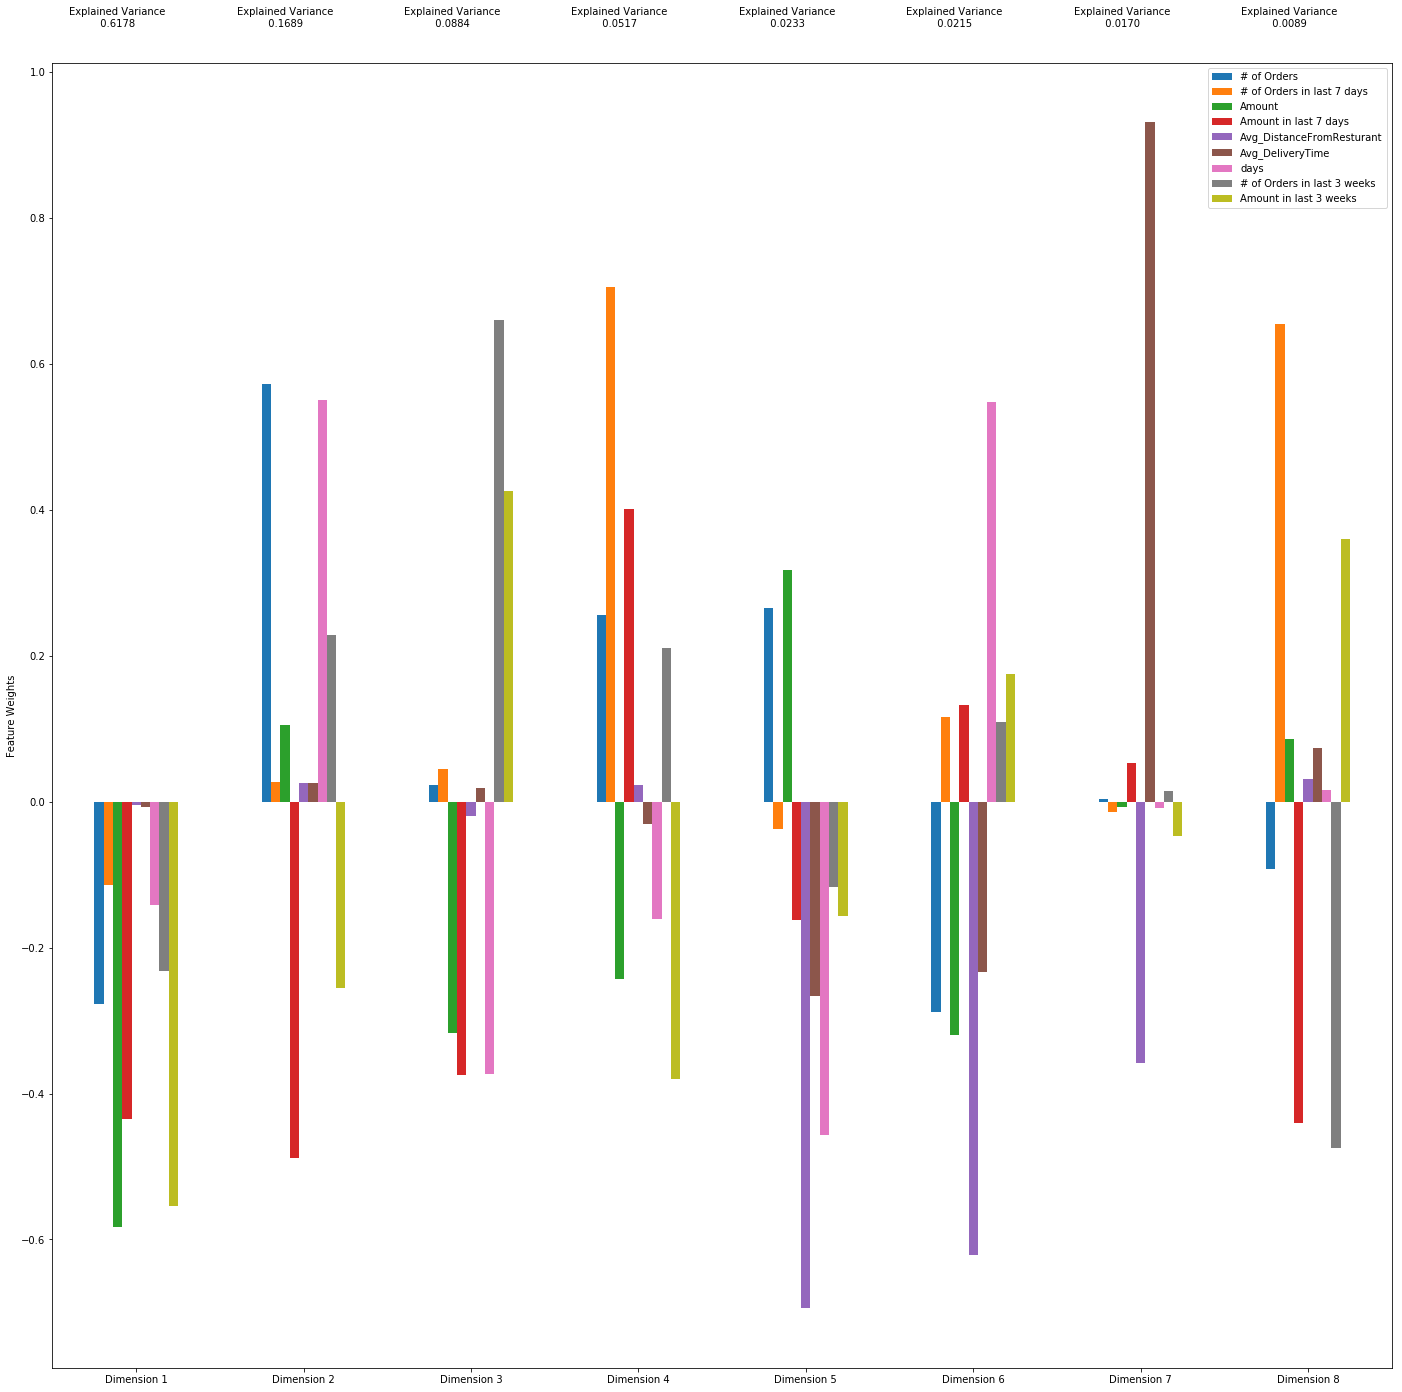

In [44]:
# Generate PCA results plot
pca_results = rs.pca_results(good_data, pca)

The first four components describe 0.9324 amoung of variance in the data.

In [45]:
# Transform the good data using the PCA fit above
reduced_data = pca.transform(good_data)

In [46]:
reduced_data

array([[-6.89844589,  0.73373438,  0.92013953, ..., -0.15375307,
         0.44865174, -0.07067054],
       [-4.49788804,  1.34947388, -0.27431723, ..., -0.62669191,
         0.20513126,  0.13451827],
       [-4.76913488,  1.29833151,  0.71995583, ..., -0.37854732,
         0.41811417,  0.13640254],
       ..., 
       [ 2.82726786, -2.27600241,  0.30859964, ..., -0.33370995,
        -0.55116649,  0.03187909],
       [ 0.16698764, -3.03006184, -0.99783501, ...,  0.08894777,
        -0.55183218, -0.4869642 ],
       [ 2.60804825, -1.95693717,  0.73346695, ..., -0.5983828 ,
         0.34421986,  0.67929771]])

# Clustering

In this section, we will choose to use either a K-Means clustering algorithm or a Gaussian Mixture Model clustering algorithm to identify the various customer segments hidden in the data.

Further, we quantify the "goodness" of a clustering by calculating each data point's silhouette coefficient. The silhouette coefficient for a data point measures how similar it is to its assigned cluster from -1 (dissimilar) to 1 (similar). Calculating the mean silhouette coefficient provides for a simple scoring method of a given clustering.

# GMM


In [47]:
from sklearn import mixture
from sklearn.metrics import silhouette_score

for i in xrange(2,20):
    g = mixture.GaussianMixture(n_components=i)
    clusterer = g.fit(reduced_data)

    # Predict the cluster for each data point
    preds = clusterer.predict(reduced_data)

    # Find the cluster centers
    centers = clusterer.means_

    # Calculate the mean silhouette coefficient for the number of clusters chosen
    score = silhouette_score(reduced_data, preds)
    print i, score

2 0.113890300163
3 0.0425670970158
4 -0.00272832578751
5 0.0163146565519
6 0.0012991327871
7 -0.0480809163002
8 -0.0416367845456
9 -0.0390164395546
10 -0.0515992415706
11 -0.0689220908573
12 -0.0880858296181
13 -0.0428612608925
14 -0.093886530973
15 -0.0931237994714
16 -0.085319775987
17 -0.106545173977
18 -0.0900452357141
19 -0.116098668344


As we can see, from the above experiments silhouette_score is best with #cluster = 2 So, the number of cluster = 2 looks like the best possibility.

In [48]:
# try with reduced dimensions

In [49]:
# Apply PCA by fitting the good data with only two dimensions
pca = PCA(n_components=2)

# Transform the good data using the PCA fit above
reduced_data = pca.fit(good_data).transform(good_data)

# Transform the sample log-data using the PCA fit above
#pca_samples = pca.transform(log_samples)

# Create a DataFrame for the reduced data
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2'])

In [50]:
# Apply your clustering algorithm of choice to the reduced data 
from sklearn.mixture import GaussianMixture 
from sklearn.metrics import silhouette_score

g = mixture.GaussianMixture(n_components=2)
clusterer = g.fit(reduced_data)

#  Predict the cluster for each data point
preds = clusterer.predict(reduced_data)

#  Find the cluster centers
centers = clusterer.means_

# Calculate the mean silhouette coefficient for the number of clusters chosen
score = silhouette_score(reduced_data, preds)
print score

0.377013862415


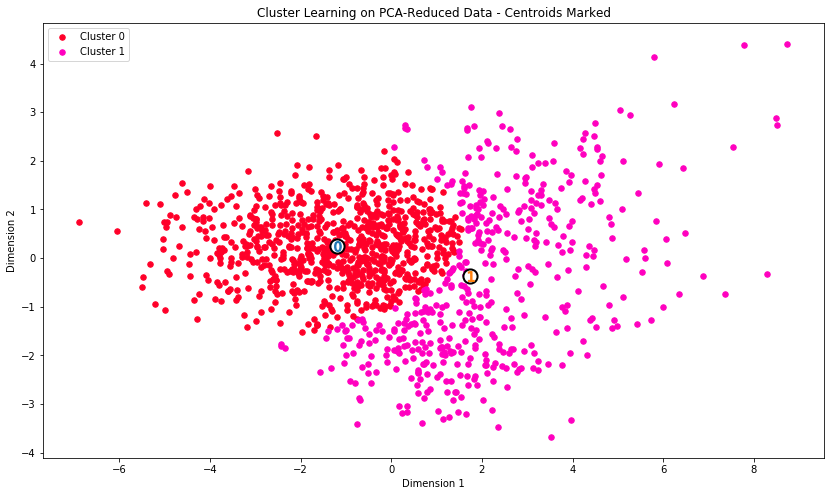

In [51]:
rs.cluster_results(reduced_data, preds, centers)

In [52]:
log_centers = pca.inverse_transform(centers)

# Exponentiate the centers
true_centers = np.exp(log_centers)

# Display the true centers
segments = ['Segment {}'.format(i) for i in range(0,len(centers))]
true_centers = pd.DataFrame(np.round(true_centers), columns = df.columns)
true_centers.index = segments
display(true_centers)

,# of Orders,# of Orders in last 7 days,Amount,Amount in last 7 days,Avg_DistanceFromResturant,Avg_DeliveryTime,days,# of Orders in last 3 weeks,Amount in last 3 weeks
Segment 0,23.0,2.0,6434.0,482.0,2.0,35.0,117.0,4.0,1134.0
Segment 1,7.0,1.0,1095.0,181.0,2.0,33.0,56.0,2.0,262.0


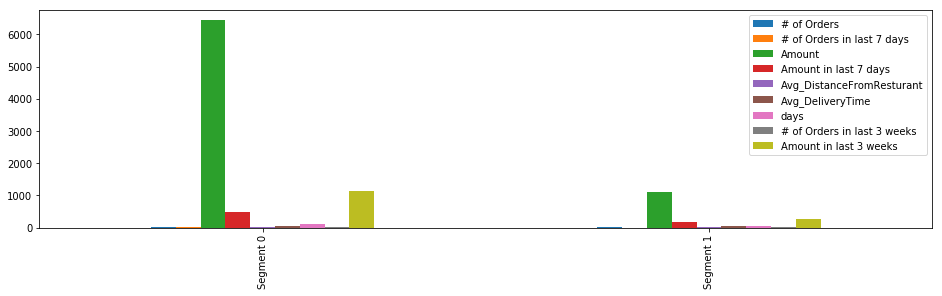

In [53]:
true_centers.plot(kind = 'bar', figsize = (16, 4))

# K-means / K-means++

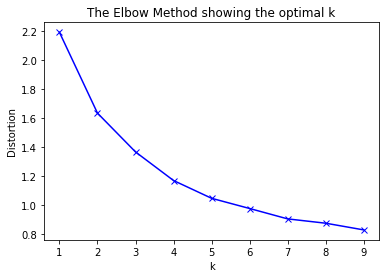

In [69]:
# k means determine k
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

distortions = []
K = range(1,10)

for k in K:
    kmeanModel = KMeans(n_clusters=k, init ='random').fit(reduced_data)
    kmeanModel.fit(reduced_data)
    distortions.append(sum(np.min(cdist(reduced_data, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / reduced_data.shape[0])
 
# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

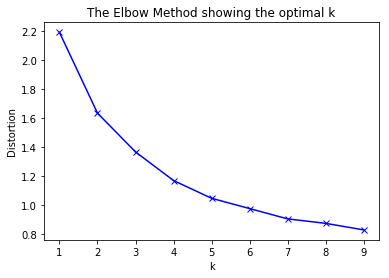

In [68]:
# k means determine k
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

distortions = []
K = range(1,10)

for k in K:
    kmeanModel = KMeans(n_clusters=k, init ='k-means++').fit(reduced_data)
    kmeanModel.fit(reduced_data)
    distortions.append(sum(np.min(cdist(reduced_data, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / reduced_data.shape[0])
 
# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

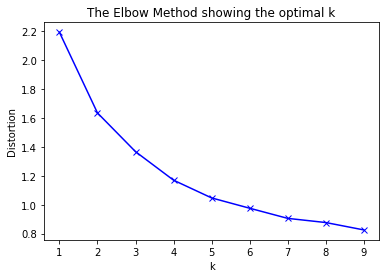

In [73]:
# k means determine k
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

distortions = []
K = range(1,10)

for k in K:
    kmeanModel = KMeans(algorithm='elkan', n_clusters=k, init ='k-means++').fit(reduced_data)
    kmeanModel.fit(reduced_data)
    distortions.append(sum(np.min(cdist(reduced_data, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / reduced_data.shape[0])
 
# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

There is no clear elbow. ploted values till k = 50. 

Tried various options for algo=, and init=

Its always a near smooth curve. Have taken K=4

In [59]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn import metrics


K = 4
kmeans = KMeans(n_clusters=K).fit(reduced_data)


In [60]:
print set(kmeans.labels_)

kmeans_labels = kmeans.labels_

kmeans_centroids = kmeans.cluster_centers_


set([0, 1, 2, 3])


In [61]:
print len(kmeans_labels)

print reduced_data.shape

1306
(1306, 2)


In [62]:
print reduced_data.shape
print type(reduced_data)

(1306, 2)
<class 'pandas.core.frame.DataFrame'>


In [63]:
reduced_data_df = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2'])
cluster_label_df = pd.DataFrame(kmeans_labels, columns = ['Cluster'])
plot_data = pd.concat([cluster_label_df, reduced_data_df], axis = 1)

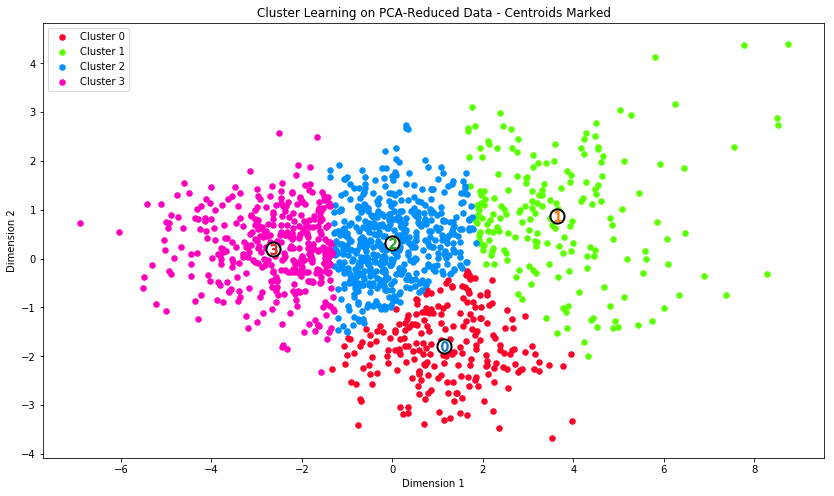

In [64]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

fig, ax = plt.subplots(figsize = (14,8))

centers = kmeans.cluster_centers_

# Color map
cmap = cm.get_cmap('gist_rainbow')

# Color the points based on assigned cluster
for i, cluster in plot_data.groupby('Cluster'):   
    cluster.plot(ax = ax, kind = 'scatter', x = 'Dimension 1', y = 'Dimension 2', \
                 color = cmap((i)*1.0/(len(centers)-1)), label = 'Cluster %i'%(i), s=30);

# Plot centers with indicators
#centers = pca.

for i, c in enumerate(centers):
    ax.scatter(x = c[0], y = c[1], color = 'white', edgecolors = 'black', \
               alpha = 1, linewidth = 2, marker = 'o', s=200);
    ax.scatter(x = c[0], y = c[1], marker='$%d$'%(i), alpha = 1, s=100);

# Plot transformed sample points 
#ax.scatter(x = pca_samples[:,0], y = pca_samples[:,1], s = 150, linewidth = 4, color = 'black', marker = 'x');

# Set plot title
ax.set_title("Cluster Learning on PCA-Reduced Data - Centroids Marked");

In [65]:
preds = kmeans_labels

centers = kmeans_centroids

In [66]:
log_centers = pca.inverse_transform(centers)

# Exponentiate the centers
true_centers = np.exp(log_centers)

# Display the true centers
segments = ['Segment {}'.format(i) for i in range(0,len(centers))]
true_centers = pd.DataFrame(np.round(true_centers), columns = df.columns)
true_centers.index = segments
display(true_centers)

,# of Orders,# of Orders in last 7 days,Amount,Amount in last 7 days,Avg_DistanceFromResturant,Avg_DeliveryTime,days,# of Orders in last 3 weeks,Amount in last 3 weeks
Segment 0,4.0,1.0,1329.0,472.0,2.0,32.0,27.0,2.0,524.0
Segment 1,9.0,1.0,410.0,43.0,2.0,34.0,84.0,2.0,66.0
Segment 2,17.0,2.0,3250.0,277.0,2.0,34.0,104.0,3.0,576.0
Segment 3,33.0,2.0,14976.0,931.0,2.0,35.0,140.0,6.0,2574.0


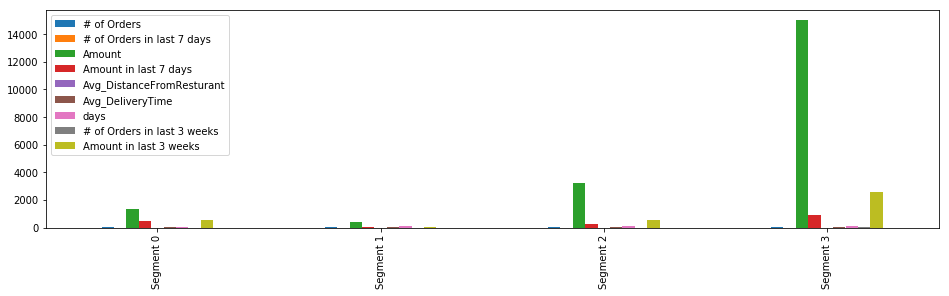

In [67]:
true_centers.plot(kind = 'bar', figsize = (16, 4))

Many values like 'Avg_DistanceFromResturant', 'Avg_DeliveryTime' are very similar in these clusters. 
Most differentiating values are 'amount', 'Amount in last 7 days', 'Amount in last 3 weeks'  

The last plot shown customers put in 4 different buckets according to spend. 